In [1]:
import numpy as np
import os
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras_preprocessing.image import load_img
from keras_preprocessing import image
from keras_preprocessing.image import img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [2]:
X = []
y = []

path="D:/data GAN"
for label in os.listdir(path):
    for directory in os.listdir(os.path.join(path,label)):
        image=load_img(os.path.join(os.path.join(path,label),directory))
        image = image.crop((121, 128, 890, 889))
        image = image.resize((150, 150))
        image=img_to_array(image)
        X.append(image)
        y.append(label) 
        #print(directory)

X = np.array(X)
y = np.array(y)

In [3]:
le = preprocessing.LabelEncoder()
le.fit(y)
y_encode = le.transform(y)

In [4]:
y_one_hot = tf.keras.utils.to_categorical(y_encode, num_classes=10)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.04, random_state=42)

In [6]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X


In [7]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [8]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [9]:
base_model = ResNet50(input_shape=(150,150, 3))

In [10]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 10,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [11]:
model = Model(inputs=base_model.input, outputs=headModel)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 75, 75, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1[0][0]']              

 res2c_branch2c (Conv2D)        (None, 37, 37, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 bn2c_branch2c (BatchNormalizat  (None, 37, 37, 256)  1024       ['res2c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_2 (Add)                    (None, 37, 37, 256)  0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 37, 37, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 res3a_bra

                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 19, 19, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 res3d_branch2a (Conv2D)        (None, 19, 19, 128)  65664       ['activation_18[0][0]']          
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 19, 19, 128)  512        ['res3d_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_19 (Activation)     (None, 19, 19, 128)  0           ['bn3d_branch2a[0][0]']          
          

 activation_27 (Activation)     (None, 10, 10, 1024  0           ['add_8[0][0]']                  
                                )                                                                 
                                                                                                  
 res4c_branch2a (Conv2D)        (None, 10, 10, 256)  262400      ['activation_27[0][0]']          
                                                                                                  
 bn4c_branch2a (BatchNormalizat  (None, 10, 10, 256)  1024       ['res4c_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_28 (Activation)     (None, 10, 10, 256)  0           ['bn4c_branch2a[0][0]']          
                                                                                                  
 res4c_bra

 bn4f_branch2a (BatchNormalizat  (None, 10, 10, 256)  1024       ['res4f_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_37 (Activation)     (None, 10, 10, 256)  0           ['bn4f_branch2a[0][0]']          
                                                                                                  
 res4f_branch2b (Conv2D)        (None, 10, 10, 256)  590080      ['activation_37[0][0]']          
                                                                                                  
 bn4f_branch2b (BatchNormalizat  (None, 10, 10, 256)  1024       ['res4f_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activatio

                                                                                                  
 res5c_branch2b (Conv2D)        (None, 5, 5, 512)    2359808     ['activation_46[0][0]']          
                                                                                                  
 bn5c_branch2b (BatchNormalizat  (None, 5, 5, 512)   2048        ['res5c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_47 (Activation)     (None, 5, 5, 512)    0           ['bn5c_branch2b[0][0]']          
                                                                                                  
 res5c_branch2c (Conv2D)        (None, 5, 5, 2048)   1050624     ['activation_47[0][0]']          
                                                                                                  
 bn5c_bran

In [13]:
base_model.load_weights("resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000002CFF58F2160> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000002CFF58F2910> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002CFF58EE850> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002CFF58EE670> False
<keras.layers.core.activation.Activation object at 0x000002CFF58F1A00> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002CFF58F15B0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002CF9FC82130> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002CF9FC7B520> False
<keras.layers.core.activation.Activation object at 0x000002CF9FC7B490> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002CF9FC623A0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002CF9FC62580> False
<keras.layers.core.activation.Activation object at 0x000

In [16]:
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

In [17]:
history=model.fit(
    X_train,y_train,
    epochs=100,
    batch_size=100,
    validation_data=(X_test,y_test)
    )

Epoch 1/100
250/250 [==============================] - 340s 1s/step - loss: 0.8450 - accuracy: 0.7444 - val_loss: 0.5382 - val_accuracy: 0.8192
Epoch 2/100
250/250 [==============================] - 336s 1s/step - loss: 0.3423 - accuracy: 0.8834 - val_loss: 0.5095 - val_accuracy: 0.8327
Epoch 3/100
250/250 [==============================] - 336s 1s/step - loss: 0.1713 - accuracy: 0.9428 - val_loss: 0.5821 - val_accuracy: 0.8375
Epoch 4/100
250/250 [==============================] - 337s 1s/step - loss: 0.1019 - accuracy: 0.9664 - val_loss: 0.5605 - val_accuracy: 0.8490
Epoch 5/100
250/250 [==============================] - 338s 1s/step - loss: 0.0715 - accuracy: 0.9763 - val_loss: 0.6636 - val_accuracy: 0.8442
Epoch 6/100
250/250 [==============================] - 339s 1s/step - loss: 0.0541 - accuracy: 0.9829 - val_loss: 0.7331 - val_accuracy: 0.8519
Epoch 7/100
250/250 [==============================] - 336s 1s/step - loss: 0.0779 - accuracy: 0.9731 - val_loss: 0.7851 - val_accuracy:

250/250 [==============================] - 337s 1s/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 1.3668 - val_accuracy: 0.8462
Epoch 58/100
250/250 [==============================] - 338s 1s/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 1.4205 - val_accuracy: 0.8510
Epoch 59/100
250/250 [==============================] - 338s 1s/step - loss: 0.0091 - accuracy: 0.9971 - val_loss: 1.5954 - val_accuracy: 0.8519
Epoch 60/100
250/250 [==============================] - 339s 1s/step - loss: 0.0322 - accuracy: 0.9908 - val_loss: 1.4775 - val_accuracy: 0.8442
Epoch 61/100
250/250 [==============================] - 338s 1s/step - loss: 0.0213 - accuracy: 0.9945 - val_loss: 1.6037 - val_accuracy: 0.8510
Epoch 62/100
250/250 [==============================] - 338s 1s/step - loss: 0.0210 - accuracy: 0.9944 - val_loss: 1.3424 - val_accuracy: 0.8587
Epoch 63/100
250/250 [==============================] - 336s 1s/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 1.3872 - val_accuracy: 0.863

In [18]:
from sklearn.metrics import confusion_matrix

y_pred=model.predict(X_test)
y_pred_one_hot=np.argmax(y_pred,axis=1)
y_test_one_hot=np.argmax(y_test,axis=1)
confusion_mat=confusion_matrix(y_test_one_hot, y_pred_one_hot)
print(confusion_mat)

33/33 [==============================] - 15s 444ms/step
[[ 47   8   1   0   0   0   0   1   0   5]
 [  5 162   5   1   0   7   6   0   3   2]
 [  1   6  99   0   0   0   0   0   0   0]
 [  1   2   0  60   0   0   3   0   1   1]
 [  0   2   0   0  89   0   0   0   2   2]
 [  0   8   0   0   0  93   2   1   3   3]
 [  0   2   3   3   0   2  60   3   1   0]
 [  0   3   2   2   0   0   4  58   4   1]
 [  3   3   0   0   3   1   3   1 180   1]
 [  2   2   1   0   1   2   0   0   4  53]]


In [19]:
report= classification_report(y_test_one_hot,y_pred_one_hot)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        62
           1       0.82      0.85      0.83       191
           2       0.89      0.93      0.91       106
           3       0.91      0.88      0.90        68
           4       0.96      0.94      0.95        95
           5       0.89      0.85      0.87       110
           6       0.77      0.81      0.79        74
           7       0.91      0.78      0.84        74
           8       0.91      0.92      0.92       195
           9       0.78      0.82      0.80        65

    accuracy                           0.87      1040
   macro avg       0.86      0.85      0.86      1040
weighted avg       0.87      0.87      0.87      1040



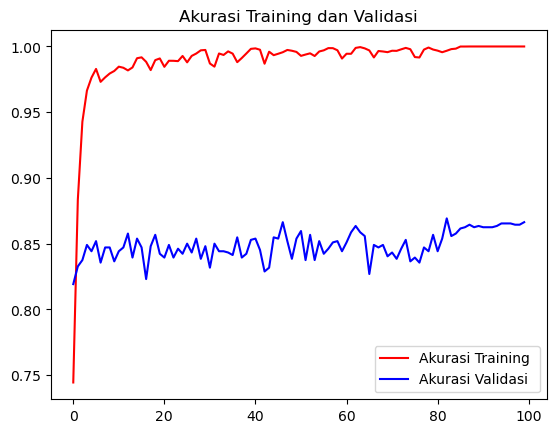

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt                                                   #Mengimpor modul matplotlib
acc = history.history['accuracy']                                                 #Nilai akurasi training
val_acc = history.history['val_accuracy']                                         #Nilai akurasi validasi
loss = history.history['loss']                                                    #Nilai loss training
val_loss = history.history['val_loss']                                            #Nilai loss validasi

epochs = range(len(acc))                                                          #Jumlah epoch

plt.plot(epochs, acc, 'r', label='Akurasi Training ')                             #Plot nilai akurasi training                     
plt.plot(epochs, val_acc, 'b', label='Akurasi Validasi')                          #Plot nilai akurasi validasi
plt.title('Akurasi Training dan Validasi')                                        #Menamai gambar
plt.legend(loc=0)                                                                 #Menampilkan legenda
plt.figure()                                                                      
plt.show()